In [ ]:
#| default_exp express

# express
> A drop-in replacement for `plotly.express` that renames all labels from snake_case to Words.

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from functools import partial, wraps
import inspect
import pandas as pd
from plotly import express
from fastcore.all import *
from pdpatch.core import *
from pdpatch.case import *

In [ ]:
#| export
def update_legend_and_yaxis(fun):
    @wraps(fun)
    def _inner(*args, **kwargs):
        fig = fun(*args, **kwargs)
        for t in fig.data:
            if hasattr(t, 'name'):
                t.update(name=px_labeler[t.name])
            if hasattr(t, 'legendgroup'):
                t.update(legendgroup=px_labeler[t.name])
            if hasattr(t, 'hovertemplate'):
                if not t.hovertemplate is None:
                    t.update(hovertemplate=t.hovertemplate.replace(t.name, px_labeler[t.name]))
        # some express functions like ecdf and histogram write their own yaxis text so we update it here
        if nested_attr(fig, 'layout.yaxis.title.text'):
            fig.update_layout(yaxis_title=px_labeler[fig.layout.yaxis.title.text])
        return fig
    return _inner

In [ ]:
#| export
class Express:
    '''Like `plotly.express` but defaults to labels=`px_labeler`'''
    def __getattr__(self, attr):
        fun = getattr(express, attr)
        docstr = fun.__doc__
        if hasattr(fun, '__call__'): 
            sig = inspect.signature(fun)
            if 'labels' in sig.parameters.keys():
                if attr=='imshow':
                    imshow_labeler = PxLabeler()
                    imshow_labeler['x'] = None
                    imshow_labeler['y'] = None
                    fun = partial(fun, labels=imshow_labeler)
                else:
                    fun = update_legend_and_yaxis(partial(fun, labels=px_labeler))
        fun.__doc__ = docstr
        return fun
    __dir__ = express.__dir__
px = Express()

In [ ]:
show_doc(Express)

---

### Express

>      Express ()

Like `plotly.express` but defaults to labels=`px_labeler`

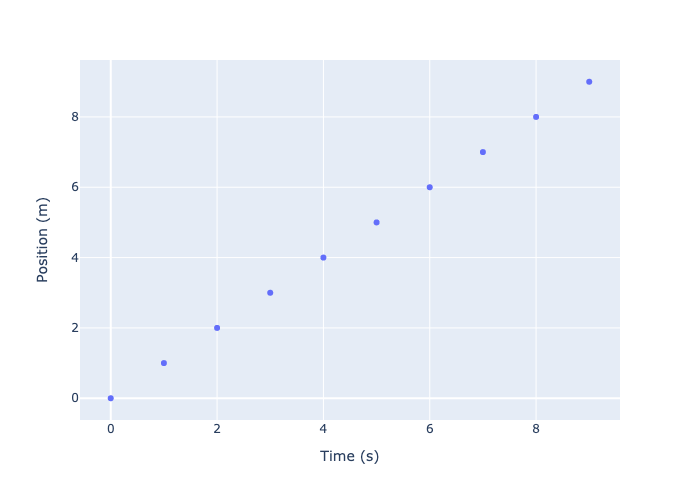

In [ ]:
df = pd.DataFrame({'time__s__': range(10), 'position__m__': range(10), 'speed__m/s__': 10*[1]})
px.scatter(df, x='time__s__', y='position__m__').show('png')

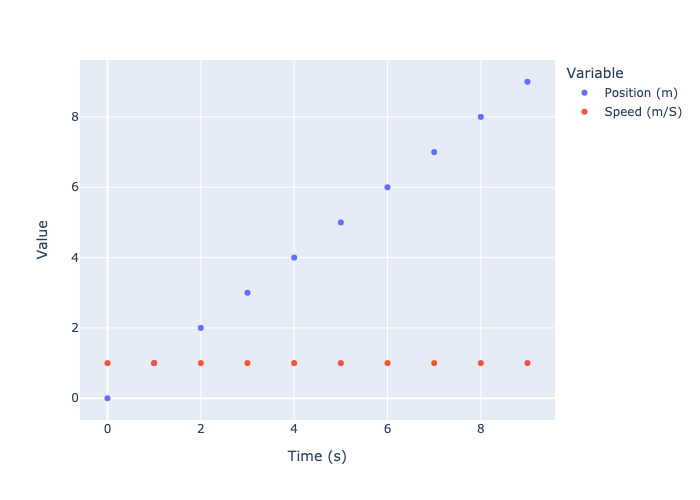

In [ ]:
df = pd.DataFrame({'time__s__': range(10), 'position__m__': range(10), 'speed__m/s__': 10*[1]})
fig = px.scatter(df,x='time__s__', y=['position__m__', 'speed__m/s__'])
fig.show(renderer="png")

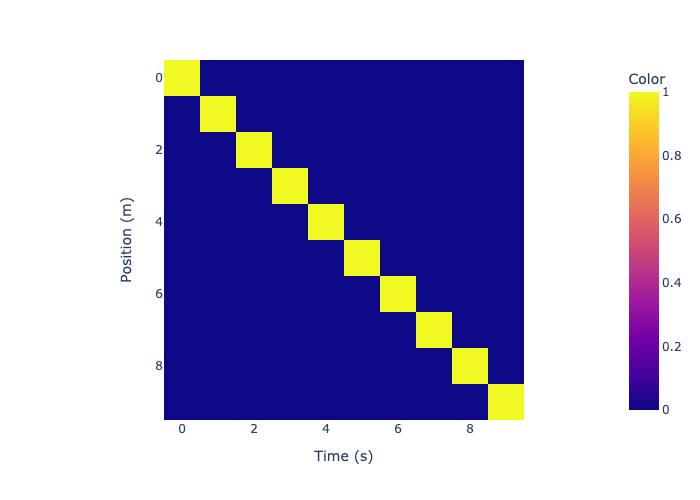

In [ ]:
df = pd.DataFrame({'time__s__': range(10), 'position__m__': range(10), 'speed__m/s__': 10*[1]})
px.imshow(df.crosstab(index='position__m__', column='time__s__')).show('png')

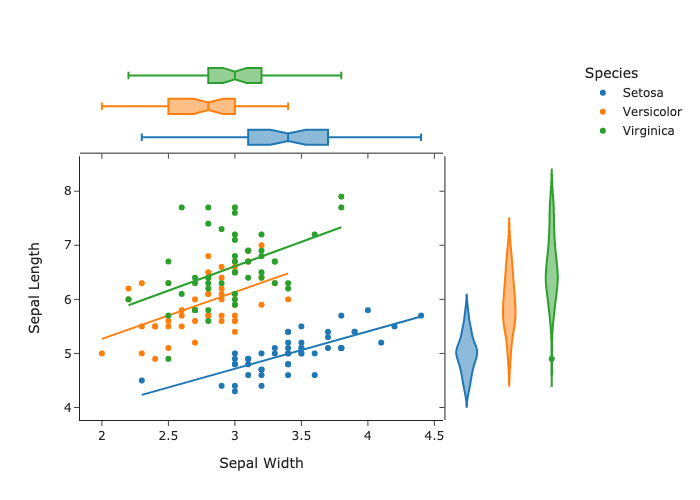

In [ ]:
df = px.data.iris()
fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show('png')

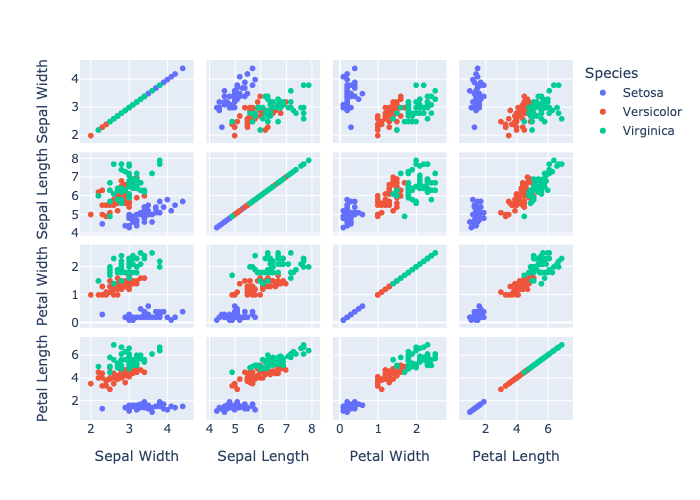

In [ ]:
df = px.data.iris()
fig = px.scatter_matrix(df, dimensions=["sepal_width", "sepal_length", "petal_width", "petal_length"], color="species")
fig.show('png')

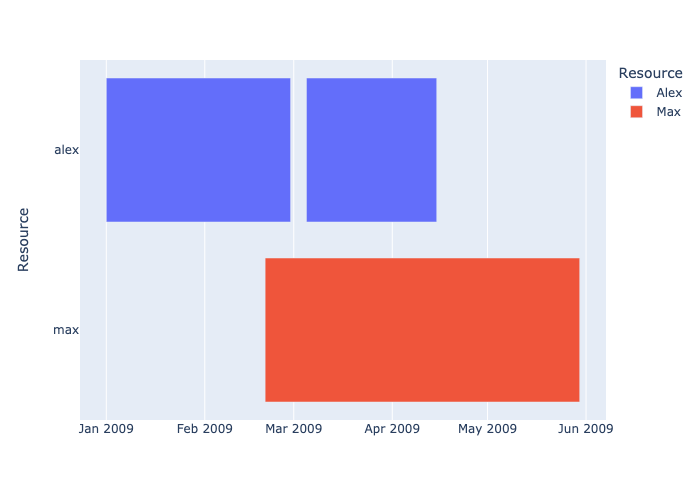

In [ ]:
df = pd.DataFrame([
    dict(task="Job A", start='2009-01-01', finish='2009-02-28', resource="alex"),
    dict(task="Job B", start='2009-03-05', finish='2009-04-15', resource="alex"),
    dict(task="Job C", start='2009-02-20', finish='2009-05-30', resource="max")
])

fig = px.timeline(df, x_start="start", x_end="finish", y="resource", color="resource")
fig.show('png')

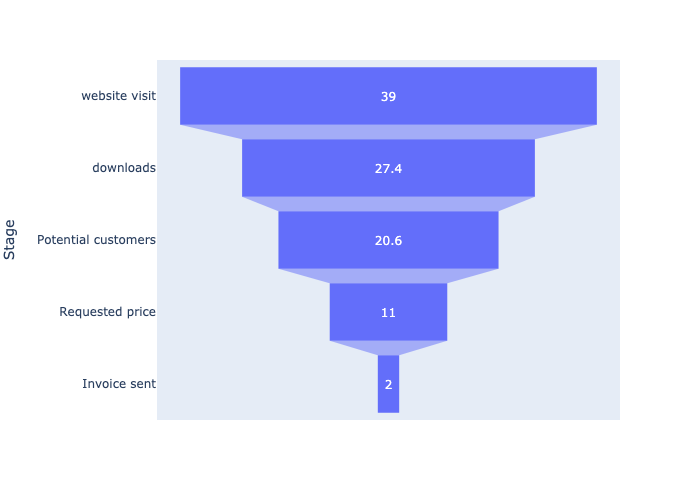

In [ ]:
data = dict(
    number=[39, 27.4, 20.6, 11, 2],
    stage=["website visit", "downloads", "Potential customers", "Requested price", "Invoice sent"])
fig = px.funnel(data, x='number', y='stage')
fig.show('png')

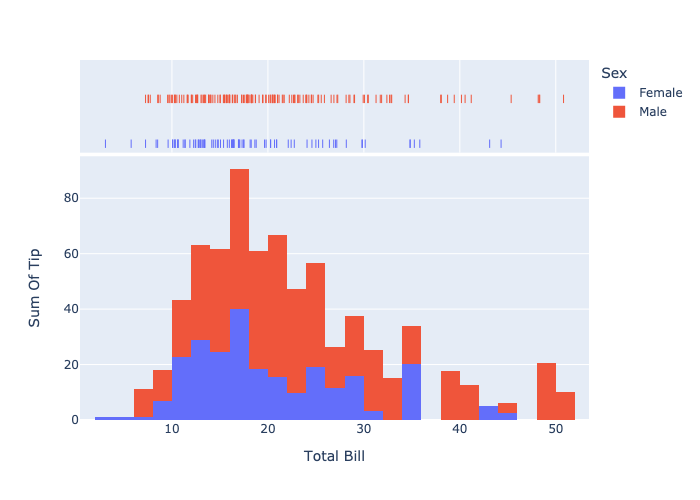

In [ ]:
df = px.data.tips()
fig = px.histogram(df, x="total_bill", y="tip", color="sex", marginal="rug", hover_data=df.columns)
fig.show('png')

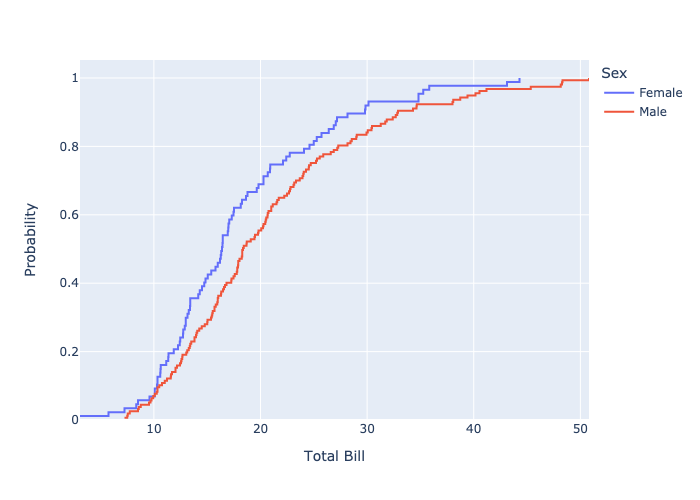

In [ ]:
df = px.data.tips()
fig = px.ecdf(df, x="total_bill", color="sex")
fig.show('png')

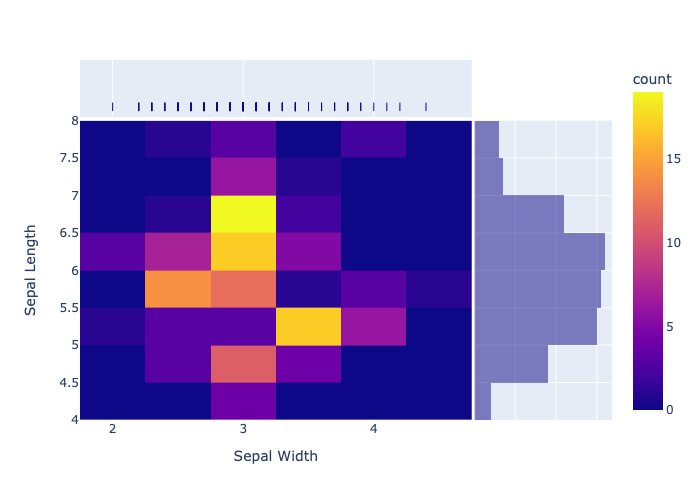

In [ ]:
df = px.data.iris()
fig = px.density_heatmap(df, x="sepal_width", y="sepal_length", marginal_x="rug", marginal_y="histogram")
fig.show('png')

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev import nbdev_export; nbdev_export()